<a href="https://colab.research.google.com/github/fellowship/deep-and-wide-bandit/blob/dev/Space_Bandits_Snippet_Kartha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs

In [1]:
!pip install space-bandits

# Imports & Data Loading 

The 2 codeblocks below, lifted from [this sample pandas-profiling notebook](https://colab.research.google.com/github/pandas-profiling/pandas-profiling/blob/master/examples/meteorites/meteorites.ipynb#scrollTo=aWCGSUOWkRDL), are apparently required to make the `pandas_profiling` package work in Google Colab :/

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

!{sys.executable} -m pip install -U pandas-profiling[notebook]
!jupyter nbextension enable --py widgetsnbextension

Requirement already up-to-date: pandas-profiling[notebook] in /usr/local/lib/python3.6/dist-packages (2.10.0)
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


For some reason, again according to the notebook linked above, restarting the kernel at this point makes it work :/ :/

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
#Downloading and loading the data onto a Dataframe
import pandas as pd
df = pd.read_csv('/content/gdrive/MyDrive/data_snippet.csv')

#Formatting .describe() calls s.t. floats are displayed in non-scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [6]:
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [7]:
df.head()

,riid,opened,rev_3dv2,unsub,campaign_type,retention_score,recency_score,frequency_score
0,242697842,1,75.00000,0,Dedicated,14.00000,1.63742,31
1,275469002,1,75.00000,0,Dedicated,2.80000,0.00000,0
2,4319542,1,19.98000,0,Dedicated,1.00000,0.08424,4
3,166170102,1,19.98000,0,Dedicated,0.75676,0.01087,1
4,6998482,1,150.00000,0,Dedicated,28.00000,1.84589,18


# EDA

In [8]:
df_size = len(df)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6240490 entries, 0 to 6240489
Data columns (total 8 columns):
 #   Column           Dtype  
---  ------           -----  
 0   riid             int64  
 1   opened           int64  
 2   rev_3dv2         float64
 3   unsub            int64  
 4   campaign_type    object 
 5   retention_score  float64
 6   recency_score    float64
 7   frequency_score  int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 380.9+ MB
None


Just 2 quick points to note:

1.   A total of 6M+ entries. We will see that the number of uniques are MUCH lesser.
2. Boolean features (open, unsub etc.) are currently int64.


In [9]:
"""
Descriptive Statistics of Features, taken one at a time.
Frequency Counts for riid, campaign type, opened & subscribed
Summary for the 3 scores & purchase

Not required with pandas_profiling

#User: riid
print("[INFO] Context — User IDs:")
df_riid = df["riid"].value_counts().rename_axis('riid').to_frame(name='counts')
print(df_riid)

#Email: Campaign Type
print("\n[INFO] Context - Campaign Type:")
df_ctype = df["campaign_type"].value_counts(normalize=True).rename_axis('Campaign Type').to_frame(name='% counts')
print(df_ctype)

#User-Email: Retention, Recency & Freqyency
print("\n[INFO] Context - Retention, Recency & Frequency Score:")
df_scores = df[["retention_score","recency_score","frequency_score"]].describe()
print(df_scores)

#Reward: Opened
print("\n[INFO] Reward - Opened/Not Opened:")
df_opened = df["opened"].value_counts(normalize=True).rename_axis('Opened (1=Yes)').to_frame(name='% counts')
print(df_opened)

#Reward: Subscribed
print("\n[INFO] Reward - Subscribed or Not:")
df_unsub = df["unsub"].value_counts(normalize=True).rename_axis('Unsubscribed (1=Yes)').to_frame(name='counts')
print(df_unsub)

#Reward: Purchased
print("\n[INFO] Reward - Purchased/Not Purchased:")
df_purchased = df[df["rev_3dv2"] > 0]
total_purchased = len(df_purchased)
percent_purchased = total_purchased/len(df)
print(f"Only {percent_purchased*100:.2f}% of people purchased. Their spends are:\n")
df_purchase_beh = df_purchased["rev_3dv2"].describe()
print(df_purchase_beh)
"""

'\nDescriptive Statistics of Features, taken one at a time.\nFrequency Counts for riid, campaign type, opened & subscribed\nSummary for the 3 scores & purchase\n\nNot required with pandas_profiling\n\n#User: riid\nprint("[INFO] Context — User IDs:")\ndf_riid = df["riid"].value_counts().rename_axis(\'riid\').to_frame(name=\'counts\')\nprint(df_riid)\n\n#Email: Campaign Type\nprint("\n[INFO] Context - Campaign Type:")\ndf_ctype = df["campaign_type"].value_counts(normalize=True).rename_axis(\'Campaign Type\').to_frame(name=\'% counts\')\nprint(df_ctype)\n\n#User-Email: Retention, Recency & Freqyency\nprint("\n[INFO] Context - Retention, Recency & Frequency Score:")\ndf_scores = df[["retention_score","recency_score","frequency_score"]].describe()\nprint(df_scores)\n\n#Reward: Opened\nprint("\n[INFO] Reward - Opened/Not Opened:")\ndf_opened = df["opened"].value_counts(normalize=True).rename_axis(\'Opened (1=Yes)\').to_frame(name=\'% counts\')\nprint(df_opened)\n\n#Reward: Subscribed\nprint(

In [10]:
profile_report = df.profile_report(
    explorative=True, html={"style": {"full_width": True}}
)
profile_report

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

A few salient points:

1. Over 0.5Mn duplicate entries.
2. ~99.9% of rev_3dv2 is 0.0
3. ~99.9% of unsub is 0
4. Both recency and frequency scores have exactly 620461 zero entries. Their distributions look like exponential decay. 
5. 4 variables are strongly correlated — opened, retention score, recency score and frequency score.
6. Specific riids have measurable interactions with the 3 scores and rev3dv2.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


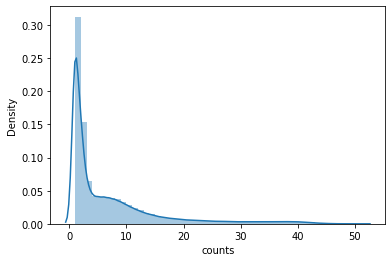

In [11]:
#Visualizing riid counts distribution to ascertain the mix of receipts in data
df_riid = df["riid"].value_counts().rename_axis('riid').to_frame(name='counts')
sns.distplot(df_riid["counts"])
plt.show()

A few points to note:

1. 1 out of 3 riids occur exactly ONCE in the dataset.
2. 15% of riids occur exactly TWICE in the dataset.

Effectively, 50%+ of riids occur $\leq$ 3 times in the dataset.

# Data Preprocessing

## Dropping Duplicate Rows

Over 0.5Mn duplicate entries in the dataframe. Eliminate them.

In [12]:
#Make a copy of the dataframe
df2 = df.copy()

#Drop duplicates
df2.drop_duplicates(keep='first', inplace=True, ignore_index=True)
i = df2.duplicated().any()
print(f"Are there any duplicates in the dataframe now? {i}")

Are there any duplicates in the dataframe now? False


## One-Hot Encoding & dtype Conversion 

1. Campaign_type has to be one-hot encoded.
2. Opened & Unsub has to converted to categorical variables.

In [13]:
#Convert only campaign-type to one-hot
campaign_one_hot = pd.get_dummies(df2["campaign_type"], prefix="Email")

#Replace old-column with new column(s)
df2.drop(columns=["campaign_type"], inplace=True)
processed_df = pd.concat([df2, campaign_one_hot], axis=1)

#Cast opened & unsub columns to categorical variables
processed_df["opened"].astype('category')
processed_df["unsub"].astype('category')

#Print the head to see 
processed_df.head()

,riid,opened,rev_3dv2,unsub,retention_score,recency_score,frequency_score,Email_Brand,Email_Collection,Email_Core,Email_Dedicated,Email_Innovation Spotlight,Email_New Arrivals,Email_Other,Email_Product Spotlight,Email_Replen,Email_Tops,Email_Trend
0,242697842,1,75.00000,0,14.00000,1.63742,31,0,0,0,1,0,0,0,0,0,0,0
1,275469002,1,75.00000,0,2.80000,0.00000,0,0,0,0,1,0,0,0,0,0,0,0
2,4319542,1,19.98000,0,1.00000,0.08424,4,0,0,0,1,0,0,0,0,0,0,0
3,166170102,1,19.98000,0,0.75676,0.01087,1,0,0,0,1,0,0,0,0,0,0,0
4,6998482,1,150.00000,0,28.00000,1.84589,18,0,0,0,1,0,0,0,0,0,0,0


## Normalizing Numeric Attributes

The descriptive statistics for each numeric attributes have different scales. We use **min-max feature scaling** to ensure they have the same scales

In [14]:
#Scale
scaler = MinMaxScaler()
numeric_columns = ["rev_3dv2","retention_score","recency_score","frequency_score"]
scaled_columns = scaler.fit_transform(processed_df[numeric_columns])
scaled_columns_df = pd.DataFrame(scaled_columns, columns=numeric_columns)

#Drop the old columns
processed_df.drop(columns=numeric_columns, inplace=True)

#Add the new ones
processed_df_normed = pd.concat([processed_df, scaled_columns_df], axis=1)
processed_df_normed.head()

,riid,opened,unsub,Email_Brand,Email_Collection,Email_Core,Email_Dedicated,Email_Innovation Spotlight,Email_New Arrivals,Email_Other,Email_Product Spotlight,Email_Replen,Email_Tops,Email_Trend,rev_3dv2,retention_score,recency_score,frequency_score
0,242697842,1,0,0,0,0,1,0,0,0,0,0,0,0,0.03974,0.49682,0.13567,0.20261
1,275469002,1,0,0,0,0,1,0,0,0,0,0,0,0,0.03974,0.09427,0.00000,0.00000
2,4319542,1,0,0,0,0,1,0,0,0,0,0,0,0,0.01059,0.02957,0.00698,0.02614
3,166170102,1,0,0,0,0,1,0,0,0,0,0,0,0,0.01059,0.02083,0.00090,0.00654
4,6998482,1,0,0,0,0,1,0,0,0,0,0,0,0,0.07948,1.00000,0.15295,0.11765


## Adding Actions column

For now, the only action is 1 (Send).

In [15]:
#Add a column with name Action to the dataframe and assign 1
processed_df_normed["Action"] = 1
processed_df_normed.head()

,riid,opened,unsub,Email_Brand,Email_Collection,Email_Core,Email_Dedicated,Email_Innovation Spotlight,Email_New Arrivals,Email_Other,Email_Product Spotlight,Email_Replen,Email_Tops,Email_Trend,rev_3dv2,retention_score,recency_score,frequency_score,Action
0,242697842,1,0,0,0,0,1,0,0,0,0,0,0,0,0.03974,0.49682,0.13567,0.20261,1
1,275469002,1,0,0,0,0,1,0,0,0,0,0,0,0,0.03974,0.09427,0.00000,0.00000,1
2,4319542,1,0,0,0,0,1,0,0,0,0,0,0,0,0.01059,0.02957,0.00698,0.02614,1
3,166170102,1,0,0,0,0,1,0,0,0,0,0,0,0,0.01059,0.02083,0.00090,0.00654,1
4,6998482,1,0,0,0,0,1,0,0,0,0,0,0,0,0.07948,1.00000,0.15295,0.11765,1


## Implementing a Reward Function

There are 3 features in the normalized dataset that can be leveraged to implement the reward function:

1.   Opened (or not)
2.   Unsubscribed (or not)
3.   (Normalized) Value of Purchase

With a [similar interpretation to Alexis](https://github.com/fellowship/deep-and-wide-bandit/blob/dev/DataExploration/RewardFunction.pdf), the reward value for each row is injected by a linear combination of the outcome features — $open$, $unsub$ and $buy$: $$r_{out features} = w_oopen + w_uunsub + w_bbuy + k$$

where $w_i$ are weights corresponding to the variables. For simplicity, we set:

1. $w_o$ to 1
2. $w_b$ to 1
3. $w_u$ to -1
4. $k$ to -1 to penalise unengaged emails. 

In [16]:
processed_df_normed["reward"] = processed_df_normed["opened"] - \
                                processed_df_normed["unsub"] + \
                                processed_df_normed["rev_3dv2"] - 1

#Eliminate all the outcome columns
processed_df_normed_with_ar = processed_df_normed.drop(columns=["opened", "unsub", "rev_3dv2"])
processed_df_normed_with_ar.head(5)

,riid,Email_Brand,Email_Collection,Email_Core,Email_Dedicated,Email_Innovation Spotlight,Email_New Arrivals,Email_Other,Email_Product Spotlight,Email_Replen,Email_Tops,Email_Trend,retention_score,recency_score,frequency_score,Action,reward
0,242697842,0,0,0,1,0,0,0,0,0,0,0,0.49682,0.13567,0.20261,1,0.03974
1,275469002,0,0,0,1,0,0,0,0,0,0,0,0.09427,0.00000,0.00000,1,0.03974
2,4319542,0,0,0,1,0,0,0,0,0,0,0,0.02957,0.00698,0.02614,1,0.01059
3,166170102,0,0,0,1,0,0,0,0,0,0,0,0.02083,0.00090,0.00654,1,0.01059
4,6998482,0,0,0,1,0,0,0,0,0,0,0,1.00000,0.15295,0.11765,1,0.07948


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


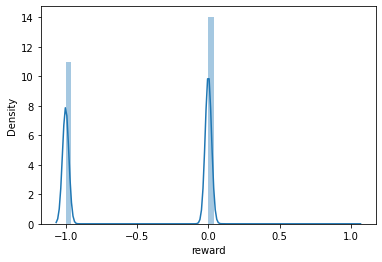

In [17]:
#What is the distribution of the rewards, as per the function?
sns.distplot(processed_df_normed_with_ar["reward"])
plt.show()


1.  Most $buy$ entries are 0 (99.9% of *rev_3dv2* entries are 0) —> they do not contribute to 99.9% of reward values. That makes the reward function $r_{out features} = w_oopen + w_uunsub + k$ for 99.9% of cases.
2.  Most (99.9%) $unsub$ entries are also 0 —> they, too, do not contribute to 99.9% of reward values. It is the equation $r_{out features} = w_oopen + k$ that holds for the vaaaast majority of the cases.
3.  There are ~60% $open=1$ and ~40% $open=0$ entries, which explains the 2 sharp peaks at $r=+1-1=0$ and $r=0-1=-1$

Sadly, for all practical purposes, our reward function effectively reduces to 0 if user opens the email and -1 otherwise.


## Generating riid embeddings

1. How do you generate sensible riid embeddings? Neither do we have a large sparse user ID vs email ID matrices, nor do we have some sequence of email ID matrices per user ID.

2. How do you generate riid embeddings for a new user? What side information do we use to map that user to the embedding space? Whatever we choose to map, should that not be the same side information that we use to map the current users as well? But, for current users, even the 3 scores are dependent on user-email_campaign (not even email ID!) cross-feature combination, right?

3. How about we average all the recency, retention & frequency scores?

## Generating Counterfactuals

The quickest way is to generate (x, ~a, -r) triplets.

In [18]:
#Get a copy
processed_df_normed_with_ar_neg = processed_df_normed_with_ar.copy()

#Convert actions from 1s to 0s
processed_df_normed_with_ar_neg["Action"] = 0

#Flip sign of reward
processed_df_normed_with_ar_neg["reward"] *= -1

#We are making some assumption here: Set all numeric columns to 0
#numeric_columns.remove("rev_3dv2")
processed_df_normed_with_ar_neg[numeric_columns] = 0
processed_df_normed_with_ar_neg.head()

#Append this new dataframe + shuffle entries
#processed_df_normed_with_ar_nosend = pd.concat([processed_df_normed_with_ar, df3], axis=0)
#processed_df_normed_with_ar_nosend = processed_df_normed_with_ar_nosend.sample(frac=1).reset_index(drop=True)
#processed_df_normed_with_ar_nosend.head(10)

,riid,Email_Brand,Email_Collection,Email_Core,Email_Dedicated,Email_Innovation Spotlight,Email_New Arrivals,Email_Other,Email_Product Spotlight,Email_Replen,Email_Tops,Email_Trend,retention_score,recency_score,frequency_score,Action,reward,rev_3dv2
0,242697842,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.03974,0
1,275469002,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.03974,0
2,4319542,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.01059,0
3,166170102,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.01059,0
4,6998482,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.07948,0


After everything, order DataFrame columns for [legibility using this](https://stackoverflow.com/questions/13148429/how-to-change-the-order-of-dataframe-columns).

# Space Bandits

Since user embeddings have not been generated, we ignore the riid column for now.

> *Context*: 11 OHE columns for category_type & the 3 Scores

> *Action*: "action" column with 0/1 values

> Reward: Real-valued "reward" column



## Purely Linear Model

In [24]:
from space_bandits import LinearBandits
from space_bandits import NeuralBandits

In [20]:
num_actions = 2
num_features = 14
linear_model = LinearBandits(num_actions, num_features, initial_pulls=100)

In [21]:
#Context: 11 OHE campaign_types, 3 scores
#2 Actions: 0/1
#Rewards: Real-valued, "rewards" column

def get_optimal_choice(index):
  send = processed_df_normed_with_ar.iloc[index, -1]
  dont_send = processed_df_normed_with_ar_neg.iloc[index, -1]
  if send > dont_send:
    return (1, send)
  else:
    return (0, dont_send)

def iterate_model(model, steps, records=None, plot_frequency=250, avg_length=150):
    """Goes through online learning simulation with model."""
    #these will track values for plotting
    if records is None:
        records = dict()
        records['timesteps'] = []
        records['c_reward'] = []
        records['cumulative_reward'] = 0
        records['m_reward'] = []
        records['maximum_reward'] = 0
        records['regret_record'] = []
        records['avg_regret'] = []
        start = 0
    else:
        start = records['timesteps'][-1]

    for i in range(start, start+steps):
        records['timesteps'].append(i)
        
        #prepare features for model
        context = (processed_df_normed_with_ar.iloc[i, 1:15]).values
        
        #Get the best choice and reward as per the dataset
        best_choice, best_reward = get_optimal_choice(i)

        #get reward for 'best' choice
        records['maximum_reward'] += best_reward
        records['m_reward'].append(records['maximum_reward'])
        action = model.action(context)

        #get reward for the action chosen by model
        if action == 1:
          reward = processed_df_normed_with_ar_neg.iloc[i,-1]
        else:
          reward = processed_df_normed_with_ar.iloc[i,-1]

        #regret is the opportunity cost of not choosing the optimal promotion
        regret = best_reward - reward
        records['regret_record'].append(regret)
        records['cumulative_reward'] += reward
        records['c_reward'].append(records['cumulative_reward'])
        model.update(context, action, reward)

        #plot occasionally
        if i <= avg_length:
            if i < avg_length:
                moving_avg=0
            else:
                moving_avg = np.array(records['regret_record']).mean()
                records['avg_regret'] = [moving_avg] * avg_length
        else:
            moving_avg = sum(records['regret_record'][-avg_length:])/avg_length
        records['avg_regret'].append(moving_avg)
        if i % plot_frequency == 0 and i > 0:
            c_rewardplt = np.array(records['c_reward'])/max(records['m_reward'])
            m_rewardplt = np.array(records['m_reward'])/max(records['m_reward'])
            regretplt = np.array(records['avg_regret'])/max(records['avg_regret'])
            
            #c_rewardplt is cumulative reward @ each time step, divided by max cumulative reward
            plt.plot(records['timesteps'], c_rewardplt, label='cumulative reward')
            
            #m_rewardplt is cumulative max reward @ each time step, divided by max cumulative reward
            plt.plot(records['timesteps'], m_rewardplt, label='maximum reward')

            #regretplt is avg_regret @ each time step, divided by max avg regret
            plt.plot(records['timesteps'], regretplt, color='red', label='mean regret')
            plt.title('Normalized Reward & Regret')
            plt.legend()
            plt.show()
    return records

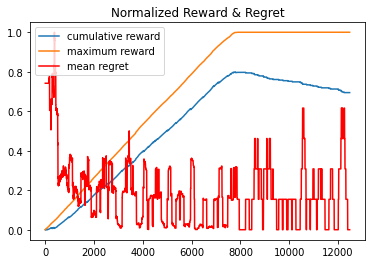

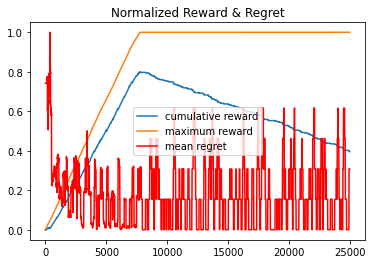

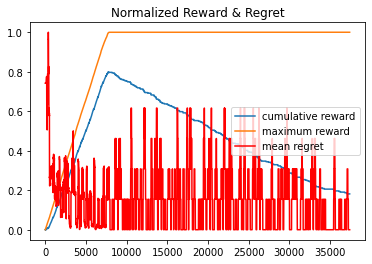

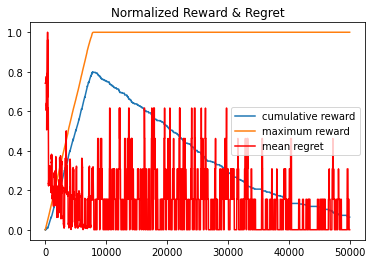

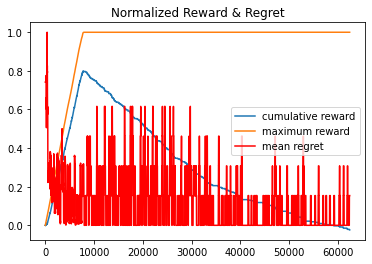

In [22]:
records_linear = iterate_model(model=linear_model, steps=df_size//100+1, plot_frequency=df_size//500)

## Non-Linear + Linear Model

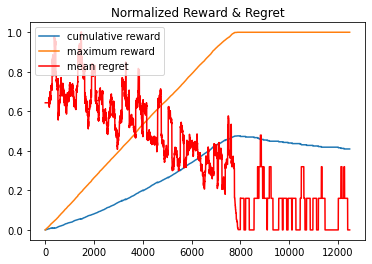

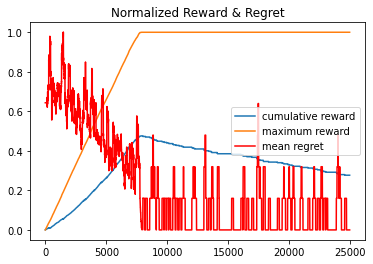

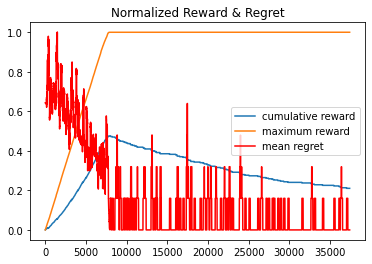

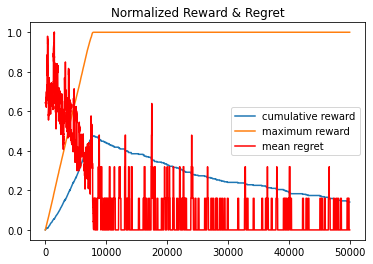

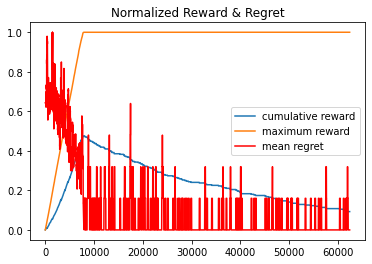

In [25]:
#Context: 11 OHE campaign_types, 3 scores
#2 Actions: 0/1
#Rewards: Real-valued, "rewards" column           
num_actions = 2
num_features = 14
memory_size = 10000
neural_model = NeuralBandits(num_actions, num_features, initial_pulls=100, memory_size=memory_size, layer_sizes=[50, 12])
assert neural_model.data_h.memory_size == memory_size

records_neural = iterate_model(model=linear_model, steps=df_size//100+1, plot_frequency=df_size//500)

## Saving the Models

In [26]:
linear_model.save('linear_model.pkl')
neural_model.save('neural_model')